# PET Weathering Simulation

This notebook contains a simulation of the degredation of polyethylene terephthalate (PET). A model from literature of combined photochemcial and thermal degradation is subjected to typical year data from the NREL database. Degredation is calculated and reported.

The model is from: 
> <em>An Arrhenius approach to estimating organic photovoltaic module weathering acceleration factors.</em> 
> <br>Olivier Haillant, David Dumbleton, Allen Zielnik. Solar Energy Materials & Solar Cells 95 (2011) 1889–1895

The "typical year" weather files is here:<br> 
> http://rredc.nrel.gov/solar/old_data/nsrdb/1991-2005/tmy3/by_state_and_city.html

The user's guide for the data sets is here:<br> 
> http://www.nrel.gov/docs/fy08osti/43156.pdf

__NOTE:__ In the work cited, the amplification factor is considered a constant.  In this simulation it was calculated as a second order function of the relative humidity.  

## Preamble

Package management.

In [2]:
import mysql.connector
import math
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

Look up available data sets using shell command.

In [3]:
!ls ./TMY_data/ | grep 'fmt'

alturas_CA_fmt.CSV
denver_CO_fmt.CSV
ely_MN_fmt.CSV
fort_lauderdale_FL_fmt.CSV
houston_TX_fmt.CSV
knoxville_TN_fmt.CSV
lafayette_IN_fmt.CSV
laramie_WY_fmt.CSV
new_york_NY_fmt.CSV
portland_OR_fmt.CSV
san_diego_CA_fmt.CSV
seattle_WA_fmt.CSV


Define dictionary of city names for plot labeling.

In [4]:
cities = {'alturas_CA':'Alturas, California',
          'denver_CO':'Denver, Colorado',
          'ely_MN':'Ely, Minnesota',
          'fort_lauderdale_FL':'Fort Lauderdale, Florida',
          'houston_TX':'Houston, Texas',
         'knoxville_TN':'Knoxville, Tennessee',
         'lafayette_IN':'Lafayette, Indiana',
         'laramie_WY':'Laramie, WY',
         'new_york_NY':'New York, New York',
         'portland_OR':'Portland, Oregon',
         'san_diego_CA':'San Diego, California',
         'seattle_WA':'Seatlle, Washington'}

Open connection to MySQL database NREL_TMY which contains weather data at specific geographic locations.

In [5]:
cnx = mysql.connector.connect(user='python_connection',
                              password='demo_pass', 
                              database='NREL_TMY')

cursor = cnx.cursor()

## Basic Experiment - Month

This experiment gets the required data set for the target month, calculates the damage and reports the results.<br>


Terms relevant to the SQL query are:

> __Time_fmt__: Properly formatted date/time string (YYYY-MM-DD-HH:mm:ss).<br><br>
__GHI__:      Irradiance measurement in $\frac{W \cdot h}{m^2}$.  See data set documentation for details.<br><br>
__Dry_bulb__: Dry-bulb temperature in $^{\circ}\!C$.<br><br>
__Rhum__:     Relative humidity as a percentage.
__Date_time__: A column of type DATETIME in the MySQL table which is created to aid in SQL queries.  See NREL_to_MySQL.ipynb in the repository.

<br>
Define the city name, month name and the query.  Check the dictionary above for available data sets and city names.

In [6]:
#city name, see dictionary above for available data sets.
city = "houston_TX"

# string - spell out the full name of the month following MySQL syntax
month_name = "June"

# MySQL string
query = ("""SELECT Time_fmt, GHI, Dry_bulb, RHum FROM """ + city 
        + """ WHERE monthname(Date_time) LIKE """ + '\'' + month_name + '\'')


Execute query

In [7]:
cursor.execute(query)

Check column names.

In [8]:
cursor.column_names

('Time_fmt', 'GHI', 'Dry_bulb', 'RHum')

### Simulation

From _Hilliant et. al._, the local damage at time $t$, $D_t$, is calculated as:

$$D_t = I_{t} A exp\left(\frac{-E_{a}}{R T_{t}}\right) \Delta t$$

Where $I_{t}$ is the irradiance at time $t$, $A$ is the pre-exponential Arrhenius factor, $E_{a}$ is the activation energy, $R$ is the universal gas constant, and $T_{t}$ is the temperature at time $t$.


In order to incorporate the effect of humidity, this simulation calculates a moisture factor as a second order function of humidity.  

$$MF = A(RH^2)$$

So the final form is:

$$D_t = I_{t} MF exp\left(\frac{-E_{a}}{R T_{t}}\right) \Delta t$$

Define constants and initialize dependent variables.

In [9]:
damage_time_local = []
time_domain = []
A = 1.5
E_a = 60
R = 8.314


Unpack rows and calculate damage.


In [10]:
for row in cursor:
    T = row[2] + 273
    I = row[1]
    MF = A*((row[3]/100)**2)
    damage_time_local.append(MF * I * math.exp(-E_a/(R*T)))
    time_domain.append(datetime.strptime(row[0], '%Y-%m-%d-%H:%M:%S'))

### Report time-local results

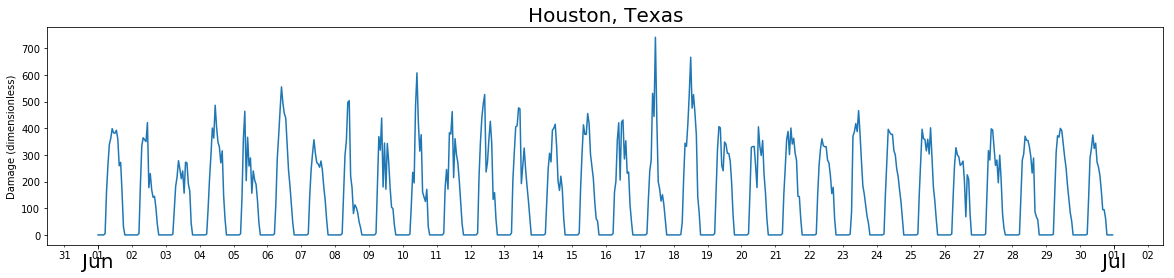

In [11]:
months = mdates.MonthLocator()  
monthsFmt = mdates.DateFormatter('%b') # use month name for axis formatting
days = mdates.DayLocator()
daysFmt = mdates.DateFormatter('%d')

fig, ax = plt.subplots(figsize=(20,4))
ax.plot(time_domain,damage_time_local)
ax.set_title(cities[city], fontsize=20)
ax.set_ylabel('Damage (dimensionless)')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_minor_formatter(daysFmt)
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.show()

### Report cumulative results

Calculate the cumulative damage as:

$$D_{cummulative,t} = \sum_{0}^{t} I_{t} MF exp\left(\frac{-E_{a}}{R T_{t}}\right) \Delta t$$

In [12]:
damage_cumulative = [sum(damage_time_local[0:x]) for x in range(len(damage_time_local))]

In [13]:
report_str = ("\n\n\nThe cumulative damage caused by photochemical, thermal, and hydrolytic decay\n" +
                     "after weathering during the month of " + month_name +
                     " in "+ cities[city] + " is: " + str(round(damage_cumulative[-1],2))+"\n\n\n")
print(report_str)




The cumulative damage caused by photochemical, thermal, and hydrolytic decay
after weathering during the month of June in Houston, Texas is: 101835.6





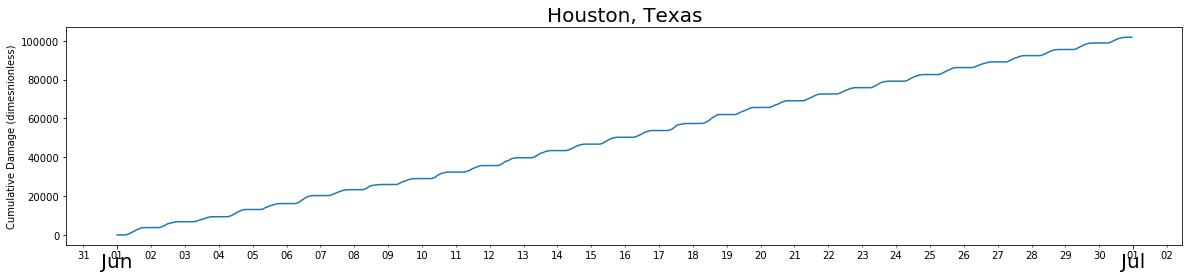

In [14]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(time_domain,damage_cumulative)
ax.set_title(cities[city], fontsize=20)
ax.set_ylabel('Cumulative Damage (dimesnionless)')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_minor_formatter(daysFmt)
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.show()

In [15]:
cnx.close()

In [16]:
damage_cumulative[-1]

101835.60184081455